In [1]:
import os
import pandas as pd
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T
import torchvision.models as models
from sklearn.model_selection import train_test_split

DATA_ROOT = r"D:\Mido\Downloads\CP-AnemiC Dataset Ghana"
EXCEL_PATH = os.path.join(DATA_ROOT, "Anemia_Data_Collection_Sheet.xlsx")

print("DATA_ROOT:", DATA_ROOT)
print("EXCEL_PATH:", EXCEL_PATH)

df = pd.read_excel(EXCEL_PATH)
print("Columns:", list(df.columns))
print("Shape:", df.shape)


DATA_ROOT: D:\Mido\Downloads\CP-AnemiC Dataset Ghana
EXCEL_PATH: D:\Mido\Downloads\CP-AnemiC Dataset Ghana\Anemia_Data_Collection_Sheet.xlsx
Columns: ['IMAGE_ID', 'HB_LEVEL', 'Severity', 'Age(Months)', 'GENDER', 'REMARK', 'HOSPITAL', 'CITY/TOWN', 'MUNICIPALITY/DISTRICT', 'REGION', 'COUNTRY']
Shape: (710, 11)


In [2]:
class EyeHbDataset(Dataset):
    """
    Image-only: IMAGE_ID -> img_tensor, HB_LEVEL -> hb_tensor
    """
    def __init__(self, excel_path, img_root, transform=None):
        df = pd.read_excel(excel_path)
        self.img_root = img_root
        self.transform = transform

        valid_rows = []
        missing = 0
        for _, row in df.iterrows():
            img_id = str(row["IMAGE_ID"])
            if not img_id.lower().endswith((".png", ".jpg")):
                fname = img_id + ".png"
            else:
                fname = img_id

            path_anemic = os.path.join(self.img_root, "Anemic", fname)
            path_non_anemic = os.path.join(self.img_root, "Non-anemic", fname)

            if os.path.exists(path_anemic):
                img_path = path_anemic
            elif os.path.exists(path_non_anemic):
                img_path = path_non_anemic
            else:
                missing += 1
                continue

            valid_rows.append({"IMAGE_ID": row["IMAGE_ID"], 
                             "HB_LEVEL": row["HB_LEVEL"], 
                             "__FULL_PATH__": img_path})

        self.df = pd.DataFrame(valid_rows)
        print("Valid images:", len(self.df), "| Missing:", missing)

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["__FULL_PATH__"]
        hb_value = float(row["HB_LEVEL"])

        img_bgr = cv2.imread(img_path)
        if img_bgr is None: raise FileNotFoundError(img_path)
        
        img_bgr = cv2.resize(img_bgr, (224, 224))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        img_tensor = self.transform(img_rgb) if self.transform else T.ToTensor()(img_rgb)
        hb_tensor = torch.tensor([hb_value], dtype=torch.float32)

        return img_tensor, hb_tensor  # img, hb only!


In [4]:
class HbNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()  # 512 image feats
        
        self.fc = nn.Sequential(
            nn.Linear(512, 256),  # Image only!
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)  # Hb prediction
        )

    def forward(self, x_img):
        feat = self.backbone(x_img)
        return self.fc(feat)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [5]:
model = HbNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for imgs, hbs in loader:
        imgs, hbs = imgs.to(device), hbs.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, hbs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, hbs in loader:
            imgs, hbs = imgs.to(device), hbs.to(device)
            preds = model(imgs)
            loss = criterion(preds, hbs)
            total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)

num_epochs = 20
best_val = float('inf')

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = eval_epoch(model, val_loader, criterion, device)
    print(f"Epoch {epoch:02d} | Train MSE: {train_loss:.4f} | Val MSE: {val_loss:.4f}")
    
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_hb_image_only.pth")
        print("  -> Saved best!")

print("Best Val MSE:", best_val)


Epoch 01 | Train MSE: 53.0980 | Val MSE: 9.9723
  -> Saved best!
Epoch 02 | Train MSE: 5.5310 | Val MSE: 4.8684
  -> Saved best!
Epoch 03 | Train MSE: 4.4107 | Val MSE: 5.8054
Epoch 04 | Train MSE: 4.0541 | Val MSE: 5.3995
Epoch 05 | Train MSE: 3.3077 | Val MSE: 5.3241
Epoch 06 | Train MSE: 3.4625 | Val MSE: 5.4529
Epoch 07 | Train MSE: 3.1673 | Val MSE: 5.3986
Epoch 08 | Train MSE: 2.8993 | Val MSE: 5.0458
Epoch 09 | Train MSE: 2.8619 | Val MSE: 5.6812
Epoch 10 | Train MSE: 2.4909 | Val MSE: 5.2061
Epoch 11 | Train MSE: 2.8570 | Val MSE: 5.0431
Epoch 12 | Train MSE: 2.4913 | Val MSE: 5.3387
Epoch 13 | Train MSE: 2.7983 | Val MSE: 5.1717
Epoch 14 | Train MSE: 2.4973 | Val MSE: 5.2577
Epoch 15 | Train MSE: 2.4561 | Val MSE: 5.4950
Epoch 16 | Train MSE: 2.1801 | Val MSE: 4.6870
  -> Saved best!
Epoch 17 | Train MSE: 2.1985 | Val MSE: 5.1908
Epoch 18 | Train MSE: 2.3992 | Val MSE: 5.0247
Epoch 19 | Train MSE: 2.3210 | Val MSE: 5.3102
Epoch 20 | Train MSE: 2.2585 | Val MSE: 5.4416
Best Val

In [6]:
def anemia_from_hb(hb): return int(hb < 12.5)  # Fixed threshold

def eval_anemia_accuracy(model, dataset, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for i in range(len(dataset)):
            img, hb_true = dataset[i]
            img = img.unsqueeze(0).to(device)
            hb_pred = model(img).item()
            
            pred_label = anemia_from_hb(hb_pred)
            true_label = anemia_from_hb(float(hb_true.item()))
            
            correct += (pred_label == true_label)
            total += 1
    return correct / total

val_acc = eval_anemia_accuracy(model, val_ds, device)
print(f"Val anemia accuracy: {val_acc*100:.1f}%")


Val anemia accuracy: 81.0%


In [30]:
num_epochs = 20
best_val = float("inf")

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss   = eval_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch:02d} | Train MSE: {train_loss:.4f} | Val MSE: {val_loss:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_hb_model.pth")
        print("  -> saved best model (Val MSE improved)")

print("Training finished. Best Val MSE:", best_val)


Epoch 01 | Train MSE: 56.0084 | Val MSE: 14.4753
  -> saved best model (Val MSE improved)
Epoch 02 | Train MSE: 5.7063 | Val MSE: 6.3307
  -> saved best model (Val MSE improved)
Epoch 03 | Train MSE: 4.2819 | Val MSE: 5.1075
  -> saved best model (Val MSE improved)
Epoch 04 | Train MSE: 3.7307 | Val MSE: 5.5931
Epoch 05 | Train MSE: 3.5877 | Val MSE: 6.1961
Epoch 06 | Train MSE: 3.2210 | Val MSE: 5.9313
Epoch 07 | Train MSE: 3.0138 | Val MSE: 6.5367
Epoch 08 | Train MSE: 3.3357 | Val MSE: 4.9738
  -> saved best model (Val MSE improved)
Epoch 09 | Train MSE: 2.7083 | Val MSE: 5.4376
Epoch 10 | Train MSE: 2.6655 | Val MSE: 4.7862
  -> saved best model (Val MSE improved)
Epoch 11 | Train MSE: 2.6393 | Val MSE: 5.6353
Epoch 12 | Train MSE: 2.6052 | Val MSE: 5.6743
Epoch 13 | Train MSE: 2.7363 | Val MSE: 5.5886
Epoch 14 | Train MSE: 2.5644 | Val MSE: 5.5166
Epoch 15 | Train MSE: 2.6003 | Val MSE: 5.3052
Epoch 16 | Train MSE: 2.3447 | Val MSE: 4.9807
Epoch 17 | Train MSE: 2.0297 | Val MSE: 5

In [8]:
def anemia_from_hb(hb): return int(hb < 12.5)  # Fixed threshold

def eval_anemia_accuracy(model, dataset, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for i in range(len(dataset)):
            img, hb_true = dataset[i]
            img = img.unsqueeze(0).to(device)
            hb_pred = model(img).item()
            
            pred_label = anemia_from_hb(hb_pred)
            true_label = anemia_from_hb(float(hb_true.item()))
            
            correct += (pred_label == true_label)
            total += 1
    return correct / total

val_acc = eval_anemia_accuracy(model, val_ds, device)
print(f"Val anemia accuracy: {val_acc*100:.1f}%")


Val anemia accuracy: 81.7%


🔍 Testing first 5 validation images:

📁 Image 1: Image_295.png
📊 True Hb: 6.8 g/dL


C:\Users\Mido\AppData\Local\Temp\ipykernel_1836\3591491730.py:34: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Mido\GradProject\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


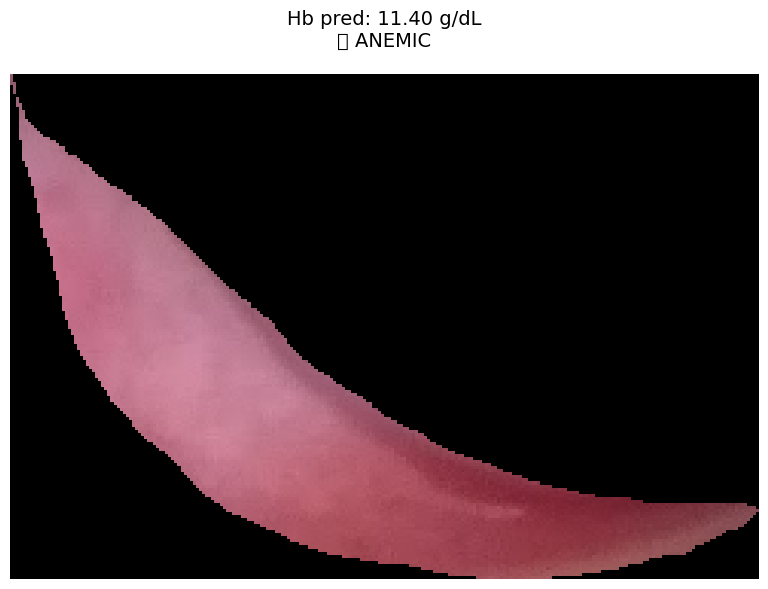

🎯 Pred Hb: 11.4 | Label: 🟡 ANEMIC
✅ Match: YES

📁 Image 2: Image_257.png
📊 True Hb: 7.0 g/dL


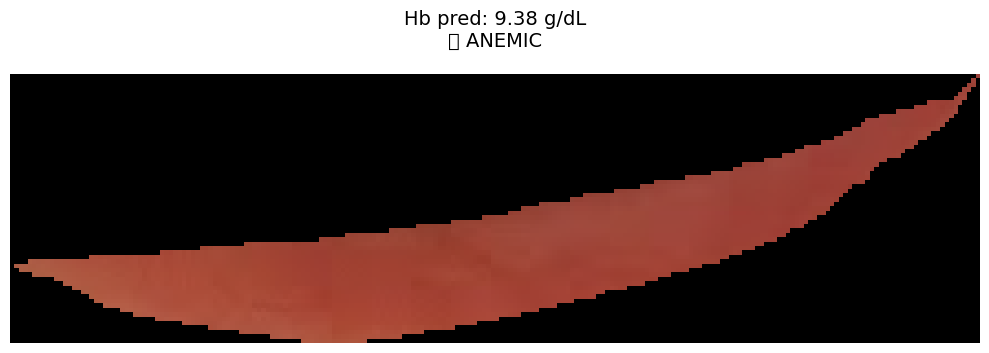

🎯 Pred Hb: 9.4 | Label: 🟡 ANEMIC
✅ Match: YES

📁 Image 3: Image_703.png
📊 True Hb: 14.7 g/dL


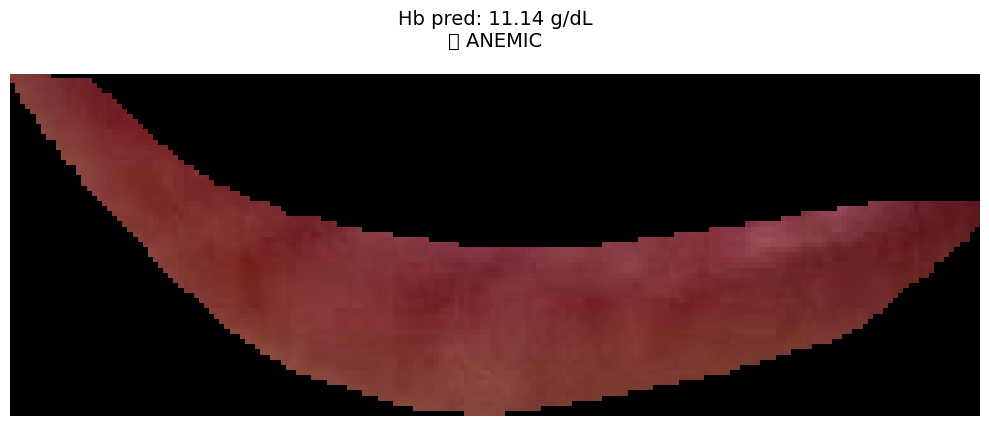

🎯 Pred Hb: 11.1 | Label: 🟡 ANEMIC
✅ Match: NO

📁 Image 4: Image_358.png
📊 True Hb: 10.5 g/dL


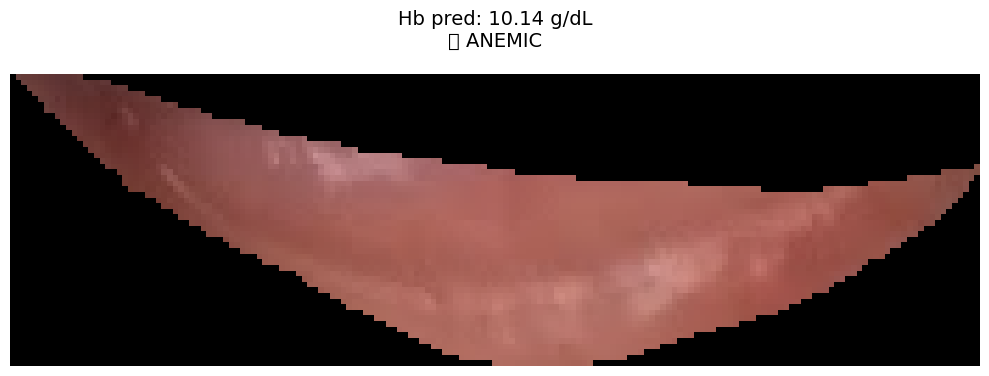

🎯 Pred Hb: 10.1 | Label: 🟡 ANEMIC
✅ Match: YES

📁 Image 5: Image_249.png
📊 True Hb: 12.0 g/dL


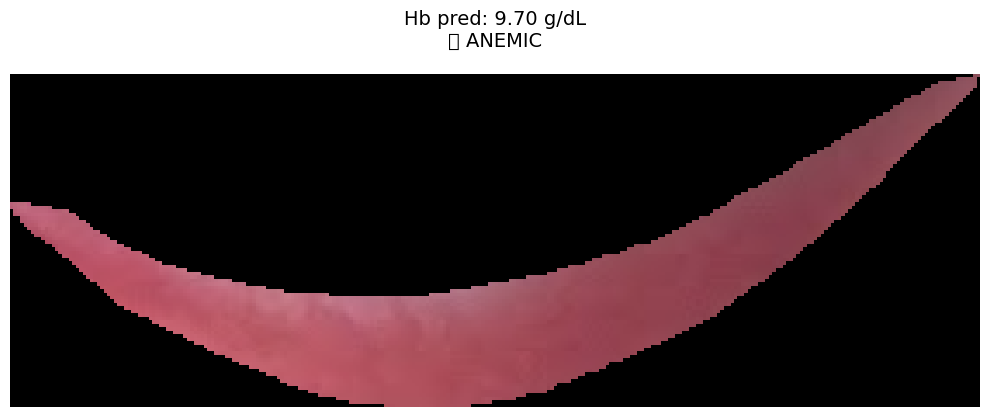

🎯 Pred Hb: 9.7 | Label: 🟡 ANEMIC
✅ Match: YES


📋 Confusion Matrix (Anemic=1, Non-anemic=0):
[[  2  24]
 [  3 113]]

📈 Classification Report:
              precision    recall  f1-score   support

  Non-anemic       0.40      0.08      0.13        26
      Anemic       0.82      0.97      0.89       116

    accuracy                           0.81       142
   macro avg       0.61      0.53      0.51       142
weighted avg       0.75      0.81      0.75       142

🎯 Overall Accuracy: 81.0%


In [10]:
import matplotlib.pyplot as plt

# Define test_transform here (no augmentation)
test_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_single(model, img_path, device, transform):
    """Predict Hb for one image, show original + predicted anemia"""
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"❌ Image not found: {img_path}")
        return None
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # Transform
    img_tensor = transform(img_rgb).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        hb_pred = model(img_tensor).item()
    
    anemia_pred = "🟡 ANEMIC" if hb_pred < 12.5 else "🟢 NON-ANEMIC"
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.title(f"Hb pred: {hb_pred:.2f} g/dL\n{anemia_pred}", fontsize=14, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return hb_pred, anemia_pred

# Test first 5 validation images
print("🔍 Testing first 5 validation images:")
for i in range(min(5, len(val_ds))):
    sample_idx = val_ds.indices[i]  # Fixed: val_ds.indices
    img_path = dataset.df.iloc[sample_idx]["__FULL_PATH__"]
    _, hb_true = dataset[sample_idx]
    
    print(f"\n📁 Image {i+1}: {os.path.basename(img_path)}")
    print(f"📊 True Hb: {hb_true.item():.1f} g/dL")
    
    hb_pred, label = predict_single(model, img_path, device, test_transform)
    if hb_pred is not None:
        true_label = "🟡 ANEMIC" if hb_true.item() < 12.5 else "🟢 NON-ANEMIC"
        print(f"🎯 Pred Hb: {hb_pred:.1f} | Label: {label}")
        print(f"✅ Match: {'YES' if label == true_label else 'NO'}")

# Full confusion matrix on val set
def full_confusion_matrix(model, dataset_subset, device):
    from sklearn.metrics import confusion_matrix, classification_report
    y_true, y_pred = [], []
    
    model.eval()
    with torch.no_grad():
        for local_idx in range(len(dataset_subset)):
            global_idx = dataset_subset.indices[local_idx]
            img, hb_true = dataset[global_idx]
            img = img.unsqueeze(0).to(device)
            
            hb_pred = model(img).item()
            
            true_label = int(hb_true.item() < 12.5)
            pred_label = int(hb_pred < 12.5)
            
            y_true.append(true_label)
            y_pred.append(pred_label)
    
    cm = confusion_matrix(y_true, y_pred)
    print("\n📋 Confusion Matrix (Anemic=1, Non-anemic=0):")
    print(cm)
    
    print("\n📈 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Non-anemic", "Anemic"]))
    
    acc = (cm[0,0] + cm[1,1]) / len(y_true)
    print(f"🎯 Overall Accuracy: {acc*100:.1f}%")
    
    return cm

print("\n" + "="*50)
cm = full_confusion_matrix(model, val_ds, device)


📊 Confusion Matrix (rows=true, cols=pred):
           Pred Non-Anemic   Pred Anemic
True Non-Anemic     3               23
True Anemic         2               114

Accuracy: 82.4%


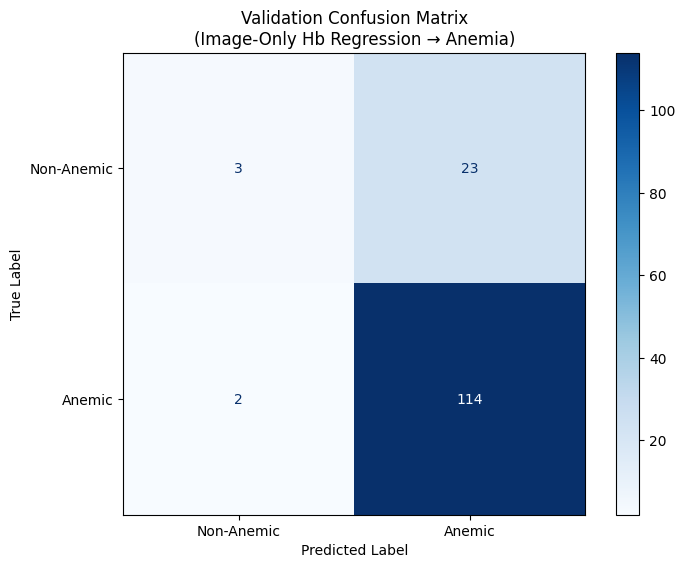


📈 Detailed Report:
              precision    recall  f1-score   support

  Non-Anemic       0.60      0.12      0.19        26
      Anemic       0.83      0.98      0.90       116

    accuracy                           0.82       142
   macro avg       0.72      0.55      0.55       142
weighted avg       0.79      0.82      0.77       142



In [11]:
# Cell 8: Generate & Plot Confusion Matrix (Run after Cell 7)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def get_predictions(model, dataset_subset, device):
    """Extract true/pred labels for CM"""
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for local_idx in range(len(dataset_subset)):
            global_idx = dataset_subset.indices[local_idx]
            img, hb_true = dataset[global_idx]
            img = img.unsqueeze(0).to(device)
            
            hb_pred = model(img).item()
            
            y_true.append(int(hb_true.item() < 12.5))      # True label
            y_pred.append(int(hb_pred < 12.5))             # Pred label
    
    return np.array(y_true), np.array(y_pred)

y_true, y_pred = get_predictions(model, val_ds, device)

# Print numbers
cm = confusion_matrix(y_true, y_pred)
print("📊 Confusion Matrix (rows=true, cols=pred):")
print("           Pred Non-Anemic   Pred Anemic")
print("True Non-Anemic    ", cm[0,0], "             ", cm[0,1])
print("True Anemic        ", cm[1,0], "             ", cm[1,1])
print(f"\nAccuracy: {(cm[0,0]+cm[1,1])/len(y_true)*100:.1f}%")

# Plot
fig, ax = plt.subplots(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=["Non-Anemic", "Anemic"])
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Validation Confusion Matrix\n(Image-Only Hb Regression → Anemia)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Per-class metrics
from sklearn.metrics import classification_report
print("\n📈 Detailed Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Anemic", "Anemic"]))


✅ Using layer: layer4.0.conv1
🧠 Generating Grad-CAM...


TypeError: unsupported format string passed to Tensor.__format__

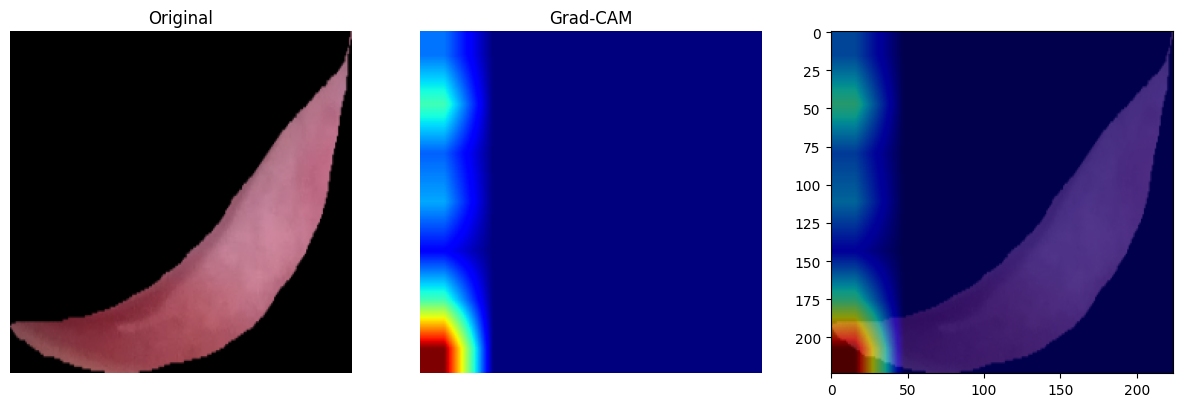

In [16]:
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Target FINAL conv layer (safe access)
def get_target_layer(model):
    for name, module in model.backbone.named_modules():
        if 'layer4' in name and isinstance(module, torch.nn.Conv2d):
            return module, name
    raise ValueError("No conv layer found!")

target_layer, layer_name = get_target_layer(model)
print(f"✅ Using layer: {layer_name}")

class SimpleGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None
        self.grads = None
        
    def hooks(self):
        def fwd_hook(m, i, o): self.feature_maps = o
        def bwd_hook(m, i, o): self.grads = o[0]
        h1 = self.target_layer.register_forward_hook(fwd_hook)
        h2 = self.target_layer.register_full_backward_hook(bwd_hook)
        return h1, h2
    
    def generate_cam(self, img_tensor, device):
        hooks = self.hooks()
        try:
            self.model.eval()
            img = img_tensor.unsqueeze(0).to(device).requires_grad_(True)
            
            out = self.model(img)
            score = out[0,0]
            self.model.zero_grad()
            score.backward()
            
            # CAM computation
            grads = self.grads.cpu()
            feats = self.feature_maps.cpu()
            weights = torch.mean(grads, dim=[2,3], keepdim=True)
            cam = torch.sum(weights * feats, dim=1).squeeze()
            cam = F.relu(cam)
            cam = cam / (cam.max() + 1e-6)
            
            # Resize
            cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), 
                               (224,224), mode='bilinear')[0,0]
            return cam.detach().numpy()
        finally:
            hooks[0].remove()
            hooks[1].remove()

# Initialize
gc = SimpleGradCAM(model, target_layer)

# TEST 1: First validation image
print("🧠 Generating Grad-CAM...")
first_idx = val_ds.indices[0]
img_orig, hb_true = dataset[first_idx]
img_path = dataset.df.iloc[first_idx]['__FULL_PATH__']

cam = gc.generate_cam(img_orig, device)
hb_pred = model(img_orig.unsqueeze(0).to(device)).item()

# Denormalize for display
img_disp = (img_orig * torch.tensor([0.229,0.224,0.225]).view(3,1,1) + 
           torch.tensor([0.485,0.456,0.406]).view(3,1,1)).clamp(0,1).permute(1,2,0).numpy()

plt.figure(figsize=(15,5))
plt.subplot(131); plt.imshow(img_disp); plt.title("Original"); plt.axis('off')
plt.subplot(132); plt.imshow(cam, cmap='jet'); plt.title("Grad-CAM"); plt.axis('off')
plt.subplot(133)
plt.imshow(img_disp); plt.imshow(cam, cmap='jet', alpha=0.6)
plt.title(f"Hb Pred: {hb_pred:.1f}\nTrue: {hb_true:.1f}"); plt.axis('off')
plt.suptitle("Grad-CAM: Red = Model Focus Areas")
plt.tight_layout(); plt.show()

print(f"✅ Image: {os.path.basename(img_path)}")
print(f"📊 Pred/True Hb: {hb_pred:.1f} / {hb_true:.1f}")
print("🔴 Red hotspots should be on conjunctiva (eye whites)!")
